In [2]:
# @title Import Libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import joblib
from collections import defaultdict

from sklearn.model_selection import KFold, cross_validate, TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import xgboost

import matplotlib.dates as mdates
from datetime import timedelta
from dateutil.relativedelta import relativedelta

In [3]:
# @title Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# drive_data_path = "/content/drive/Shareddrives/Ishango/Programs/AIMS_MSc_Theses_Supervision/AIWP/Project26_MLStacking/data/oliver/"
# df = pd.read_pickle(drive_data_path + "era5_ml_setup_500geopotential_32x64_2020.pkl")
# data_path = "/content/drive/MyDrive/_shared_drive_shortcut/MastersProject/Data/"

# data_path = "/content/drive/MyDrive/_shared/MastersProject/Data/"
# data_plot_path = "/content/drive/MyDrive/_shared/MastersProject/Plots/"

data_path="/content/drive/MyDrive/MastersProject/Data/"
data_plot_path="/content/drive/MyDrive/MastersProject/Plots/"


In [5]:
# @title Load forecasts & ERA5 truth

df =pd.read_pickle(data_path+"era5_ml_setup_500geopotential_32x64_2020.pkl")

# lead_times=[48, 72, 96, 120, 144, 168, 192, 216, 240]
lead_times=[48]

for lead_time in lead_times:
    print(lead_time)
    df_aiwp = pd.read_pickle(data_path + f"aiwp_ml_setup_500geopotential_32x64_2020_leadtime{lead_time}.pkl").drop(columns=["area_weight"])
    df_aiwp = df_aiwp.rename(columns={col: col + "_lt" + str(lead_time) for col in df_aiwp.columns if col not in ["time", "longitude", "latitude"]})
    if lead_time == 48:
      df_aiwp_full = df_aiwp
    else:
      df_aiwp_full = df_aiwp_full.merge(df_aiwp, on=["time", "longitude", "latitude"], how="outer")

print(f"Shape of df :{df.shape}")
print(f"Shape of df_aiwp_full :{df_aiwp_full.shape}")



48
Shape of df :(1556480, 5)
Shape of df_aiwp_full :(1499136, 8)


In [6]:
df_aiwp_full.isna().sum()

,0
time,0
longitude,0
latitude,0
graphcast_lt48,0
pangu_lt48,0
neuralgcm_lt48,0
keisler_lt48,32768
ifshres_lt48,0


In [7]:
# @title Merge ERA5 and Forecasts Across all lead times
full_df = df.merge(df_aiwp_full, on=["time", "longitude", "latitude"], how="outer")
print(full_df.shape)
full_df.head()


(1556480, 10)


,time,longitude,latitude,era5,area_weight,graphcast_lt48,pangu_lt48,neuralgcm_lt48,keisler_lt48,ifshres_lt48
0,2020-01-01,0.0,-87.1875,49846.941406,0.049068,NaN,NaN,NaN,NaN,NaN
1,2020-01-01,0.0,-81.5625,50196.523438,0.146730,NaN,NaN,NaN,NaN,NaN
2,2020-01-01,0.0,-75.9375,50391.101562,0.242980,NaN,NaN,NaN,NaN,NaN
3,2020-01-01,0.0,-70.3125,49667.398438,0.336890,NaN,NaN,NaN,NaN,NaN
4,2020-01-01,0.0,-64.6875,49277.945312,0.427555,NaN,NaN,NaN,NaN,NaN


In [8]:
full_df.isna().sum()

,0
time,0
longitude,0
latitude,0
era5,0
area_weight,0
graphcast_lt48,57344
pangu_lt48,57344
neuralgcm_lt48,57344
keisler_lt48,90112
ifshres_lt48,57344


In [9]:
sel_cols = ['time','longitude','latitude','era5','area_weight'] + [f'keisler_lt{lt}' for lt in lead_times]
full_df[(full_df['time']> '2020-01-06')& (full_df['time']<'2021-01-05')][sel_cols].isna().sum()

,0
time,0
longitude,0
latitude,0
era5,0
area_weight,0
keisler_lt48,40960


In [10]:
# @title Filter for subset of data for each lead time

def data_per_lead_time(df,lead_time):
  valid_time_lower = df['time'][0]+timedelta(days=int(lead_time/24))
  valid_time_upper = valid_time_lower + relativedelta(years=1)
  df_filtered = df[(df['time'] > valid_time_lower) & (df['time'] < valid_time_upper)]
  return df_filtered[['time','latitude','longitude',"era5","area_weight",
                      f'graphcast_lt{lead_time}',
                      f'pangu_lt{lead_time}',
                      f'neuralgcm_lt{lead_time}',
                      # f'keisler_lt{lead_time}'
                      f'ifshres_lt{lead_time}'
                      ]]


In [11]:
for lead_time in lead_times:
  print(f"========{lead_time}=======")
  df_filter=data_per_lead_time(full_df,lead_time)
  print(df_filter[df_filter.isna().any(axis=1)]["time"].value_counts())

========48=======
Series([], Name: count, dtype: int64)


In [12]:
# @title Plot the train-test splits for each Fold

def cross_validation_plot(df, cv, lead_time):
  # Extract datetime info using the filtered df
  time_index = df["time"].reset_index(drop=True)

  X = df[[f"graphcast_lt{lead_time}", f"pangu_lt{lead_time}",
          f"neuralgcm_lt{lead_time}",
          # f"keisler_lt{lead_time}",
          f"ifshres_lt{lead_time}", "longitude", "latitude"]]

  # Store train/test index lists
  train_indices_list = []
  test_indices_list = []
  for train_index, test_index in cv.split(X):
      train_indices_list.append(train_index)
      test_indices_list.append(test_index)


  # Create the plot
  fig, ax = plt.subplots(figsize=(12, 6))

  # Plot each fold
  for i in range(10):
      # Convert indices to datetime for x-axis
      train_times = time_index.iloc[train_indices_list[i]]
      print(f"Train times Min Date: {train_times.min()} Train times Max Date:{train_times.max()}")
      test_times = time_index.iloc[test_indices_list[i]]
      print(f"Test times Min Date: {test_times.min()} Test times Max Date:{test_times.max()}")


      ax.plot(train_times, [i + 1] * len(train_times), 'bo', label='Train' if i == 0 else "", markersize=5)
      ax.plot(test_times, [i + 1] * len(test_times), 'ro', label='Test' if i == 0 else "", markersize=5)
      ax.axhline(y=i + 1.5, color='lightgray', linestyle='--')

  # Format x-axis as months
  ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))

  # Labels and title
  ax.set_xlabel('Month')
  ax.set_ylabel('Fold')
  ax.set_yticks(range(1, 11))
  ax.set_yticklabels([f'Fold {i+1}' for i in range(10)])
  ax.set_title(f'Training, Gap and Testing Windows Across 10 Folds for {lead_time} hours lead time.')
  ax.legend(loc='upper right')

  # Improve layout and save
  plt.tight_layout()
  # plt.savefig(data_plot_path + f'Training_Testing_Folds_By_Month_{lead_time}.pdf',
  #             dpi=300, bbox_inches="tight")

  plt.show()


In [13]:
# @title RMSE Comparison for each model and fold

def train_and_evaluate(xgb, cv,X,y, area_weight,lead_time):
  # Create a dictionary to store the results for each fold
  results = {}

  for fold, (train_index, test_index) in enumerate(cv.split(X)):
      print(f"Fold {fold+1}:")
      fold_results = {}

      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]

      xgb.fit(X_train, y_train, sample_weight=area_weight.iloc[train_index])

      y_pred = xgb.predict(X_test)
      mse = mean_squared_error(y_test, y_pred)
      print(f"  mse: {mse}")

      area_weighted_rmse = np.sqrt(((y_test-y_pred)**2 * area_weight.iloc[test_index]).mean() / area_weight.iloc[test_index].mean())
      print(f"  PiggyCast: area weighted rmse: {area_weighted_rmse}")
      fold_results["PiggyCast"] = area_weighted_rmse

      for model in [f"graphcast_lt{lead_time}",
                    f"pangu_lt{lead_time}",
                    f"neuralgcm_lt{lead_time}",
                    # f"keisler_lt{lead_time}",
                    f"ifshres_lt{lead_time}"]:
          area_weighted_rmse = np.sqrt(((y_test-X_test[model])**2 * area_weight.iloc[test_index]).mean() / area_weight.iloc[test_index].mean())
          print(f"  {model.split('_')[0]}: area weighted rmse: {area_weighted_rmse}")
          fold_results[model.split('_')[0]] = area_weighted_rmse

      results[fold+1] = fold_results
  return results



In [14]:
# @title Plot RMSE per fold and Model
def rmse_per_fold_plot(results, lead_time):
  fig, ax = plt.subplots(figsize=(8, 6))

  for model in results[1].keys():  # Iterate through all model names
      rmse_values = [results[fold][model] for fold in results]
      fold_numbers = list(results.keys())
      ax.plot(fold_numbers, rmse_values, label=model, marker='o')

  ax.set_xlabel('Fold')
  ax.set_ylabel('RMSE')
  ax.set_title(f'RMSE for Each Fold and Model at {lead_time} hours lead time.')
  ax.legend(loc="upper right")
  plt.grid(True)
  # plt.savefig(data_plot_path + f'RMSE_for_Each_Fold_and_Model_{lead_time}.pdf', dpi=300, bbox_inches="tight")

  plt.show()


======Lead time: 48========
Shape of x :(1497088, 6)
Shape of y : (1497088,)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:42:33] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Train times Min Date: 2020-01-04 00:00:00 Train times Max Date:2020-03-03 12:00:00
Test times Min Date: 2020-03-09 00:00:00 Test times Max Date:2020-04-07 12:00:00
Train times Min Date: 2020-02-03 00:00:00 Train times Max Date:2020-04-02 12:00:00
Test times Min Date: 2020-04-08 00:00:00 Test times Max Date:2020-05-07 12:00:00
Train times Min Date: 2020-03-04 00:00:00 Train times Max Date:2020-05-02 12:00:00
Test times Min Date: 2020-05-08 00:00:00 Test times Max Date:2020-06-06 12:00:00
Train times Min Date: 2020-04-03 00:00:00 Train times Max Date:2020-06-01 12:00:00
Test times Min Date: 2020-06-07 00:00:00 Test times Max Date:2020-07-06 12:00:00
Train times Min Date: 2020-05-03 00:00:00 Train times Max Date:2020-07-01 12:00:00
Test times Min Date: 2020-07-07 00:00:00 Test times Max Date:2020-08-05 12:00:00
Train times Min Date: 2020-06-02 00:00:00 Train times Max Date:2020-07-31 12:00:00
Test times Min Date: 2020-08-06 00:00:00 Test times Max Date:2020-09-04 12:00:00
Train times Min 

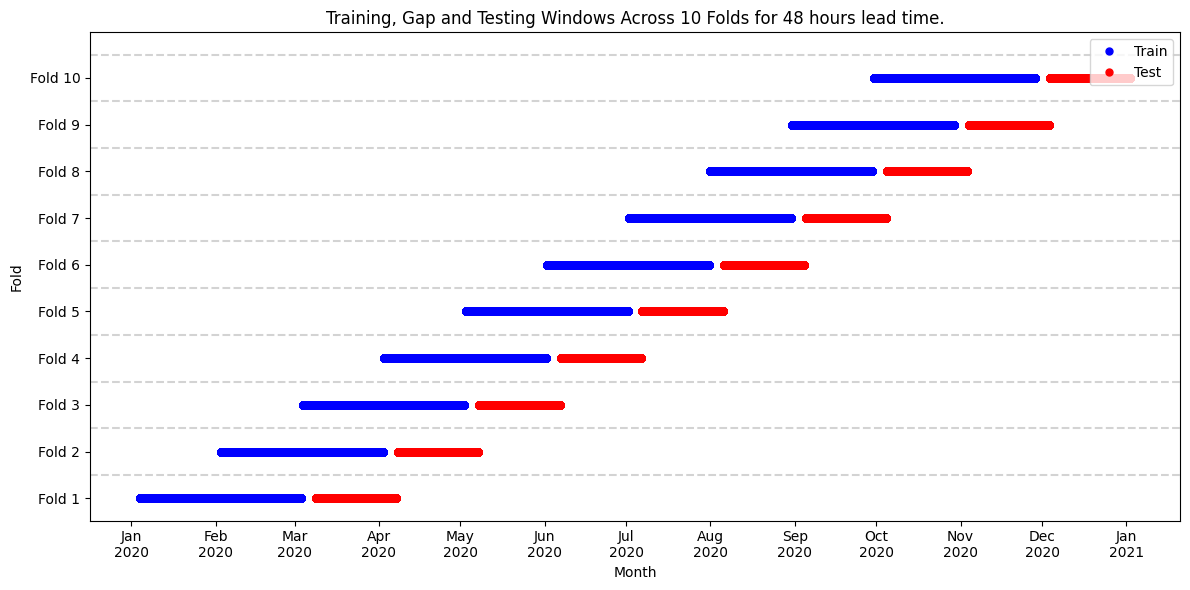

Fold 1:
  mse: 15209.0927734375
  PiggyCast: area weighted rmse: 76.76277746972184
  graphcast: area weighted rmse: 72.89521727913798
  pangu: area weighted rmse: 81.53557879205798
  neuralgcm: area weighted rmse: 61.32865112702906
  ifshres: area weighted rmse: 77.69317822238818
Fold 2:
  mse: 9210.8720703125
  PiggyCast: area weighted rmse: 66.86750469041097
  graphcast: area weighted rmse: 70.89595346008002
  pangu: area weighted rmse: 80.0969255422813
  neuralgcm: area weighted rmse: 62.04284877201307
  ifshres: area weighted rmse: 76.40121126092066
Fold 3:
  mse: 7203.16845703125
  PiggyCast: area weighted rmse: 64.48324208575639
  graphcast: area weighted rmse: 70.5749420055696
  pangu: area weighted rmse: 74.76480428843476
  neuralgcm: area weighted rmse: 61.50660557160111
  ifshres: area weighted rmse: 74.98039911101573
Fold 4:
  mse: 10929.08203125
  PiggyCast: area weighted rmse: 74.77433859172058
  graphcast: area weighted rmse: 67.91825353957019
  pangu: area weighted rmse:

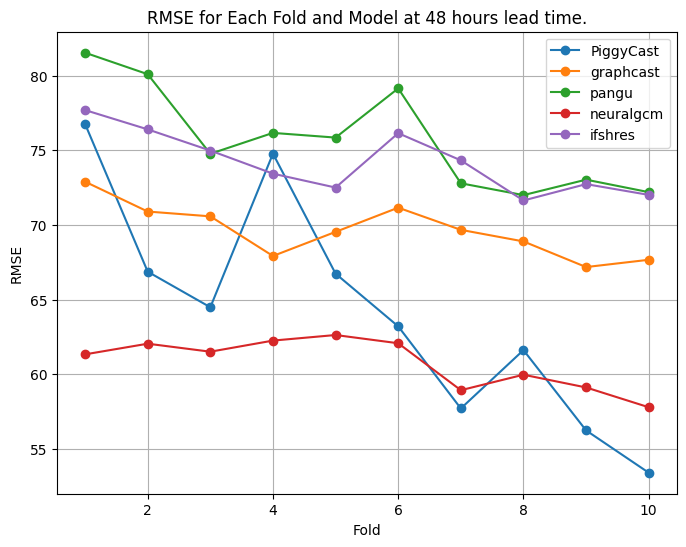

In [16]:
# @title Training and Evaluation Loop - Longer time series split

# Initialize xgb regressor
xgb = xgboost.XGBRegressor(random_state=42, device="cuda")

# Calculate Cross-Validation using 10 folds
cv_timeseries = TimeSeriesSplit(n_splits=10, max_train_size=32 * 64 * 2 * 60,
                                test_size= 32 * 64 * 2 * 30, gap=32 * 64 * 2 * 5)

# Lead Times
lead_times=[48]

nested_scores = {} # Nested scores for each lead time
rmse_results = {} # rmse results for each lead time, models

for lead_time in lead_times:
  print(f"======Lead time: {lead_time}========")

  df_filtered = data_per_lead_time(full_df,lead_time)

  X = df_filtered[[f"graphcast_lt{lead_time}", f"pangu_lt{lead_time}",
                   f"neuralgcm_lt{lead_time}",
                  #  f"keisler_lt{lead_time}",
                   f"ifshres_lt{lead_time}", "longitude", "latitude"]]
  y = df_filtered["era5"]
  area_weight = df_filtered["area_weight"]

  print(f"Shape of x :{X.shape}")
  print(f"Shape of y : {y.shape}")

  # Nested Scores
  nested_score = cross_validate(xgb, X=X, y=y, cv=cv_timeseries,
                              scoring=('neg_mean_squared_error', 'r2'),
                              params={'sample_weight': area_weight}
                              )
  nested_scores[lead_time] = nested_score

  # Cross validation plot
  cross_validation_plot(df_filtered, cv_timeseries, lead_time)

  # RMSE
  rmse_result = train_and_evaluate(xgb, cv_timeseries,X,y, area_weight, lead_time)
  rmse_results[lead_time] = rmse_result

  # RMSE plots per model
  rmse_per_fold_plot(rmse_result, lead_time)



Train times Min Date: 2020-01-04 00:00:00 Train times Max Date:2020-03-03 12:00:00
Test times Min Date: 2020-03-09 00:00:00 Test times Max Date:2020-04-07 12:00:00
Train times Min Date: 2020-02-03 00:00:00 Train times Max Date:2020-04-02 12:00:00
Test times Min Date: 2020-04-08 00:00:00 Test times Max Date:2020-05-07 12:00:00
Train times Min Date: 2020-03-04 00:00:00 Train times Max Date:2020-05-02 12:00:00
Test times Min Date: 2020-05-08 00:00:00 Test times Max Date:2020-06-06 12:00:00
Train times Min Date: 2020-04-03 00:00:00 Train times Max Date:2020-06-01 12:00:00
Test times Min Date: 2020-06-07 00:00:00 Test times Max Date:2020-07-06 12:00:00
Train times Min Date: 2020-05-03 00:00:00 Train times Max Date:2020-07-01 12:00:00
Test times Min Date: 2020-07-07 00:00:00 Test times Max Date:2020-08-05 12:00:00
Train times Min Date: 2020-06-02 00:00:00 Train times Max Date:2020-07-31 12:00:00
Test times Min Date: 2020-08-06 00:00:00 Test times Max Date:2020-09-04 12:00:00
Train times Min 

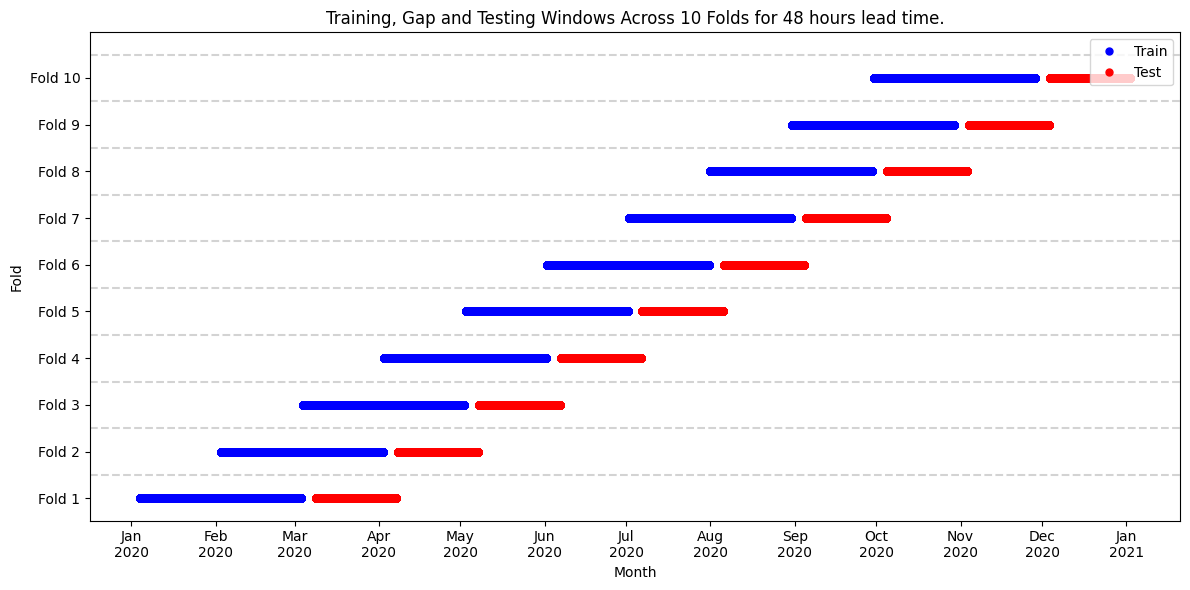

In [17]:
cv_timeseries = TimeSeriesSplit(n_splits=10, max_train_size=32 * 64 * 2 * 60,
                                test_size= 32 * 64 * 2 * 30, gap=32 * 64 * 2 * 5)
cross_validation_plot(df=df_filtered, cv=cv_timeseries, lead_time=48)

In [18]:
import pandas as pd

# Parameters
n_samples = 1_497_088
n_splits = 10
max_train_size = 32 * 64 * 2 * 60  # 245,760
test_size = 32 * 64 * 2 * 30        # 122,880
gap = 32 * 64 * 2 * 5              # 20,480

# Calculate fold boundaries
folds = []
for i in range(n_splits):
    test_end = n_samples - (n_splits - 1 - i) * test_size
    test_start = test_end - test_size
    train_end = test_start - gap
    train_start = max(0, train_end - max_train_size)

    folds.append({
        "Fold": i + 1,
        "Train Start": train_start,
        "Train End": train_end - 1,
        "Gap Start": train_end,
        "Gap End": test_start - 1,
        "Test Start": test_start,
        "Test End": test_end - 1,
        "Train Size": train_end - train_start,
        "Test Size": test_size,
    })

# Convert to DataFrame
folds_df = pd.DataFrame(folds)
folds_df


,Fold,Train Start,Train End,Gap Start,Gap End,Test Start,Test End,Train Size,Test Size
0,1,2048,247807,247808,268287,268288,391167,245760,122880
1,2,124928,370687,370688,391167,391168,514047,245760,122880
2,3,247808,493567,493568,514047,514048,636927,245760,122880
3,4,370688,616447,616448,636927,636928,759807,245760,122880
4,5,493568,739327,739328,759807,759808,882687,245760,122880
5,6,616448,862207,862208,882687,882688,1005567,245760,122880
6,7,739328,985087,985088,1005567,1005568,1128447,245760,122880
7,8,862208,1107967,1107968,1128447,1128448,1251327,245760,122880
8,9,985088,1230847,1230848,1251327,1251328,1374207,245760,122880
9,10,1107968,1353727,1353728,1374207,1374208,1497087,245760,122880


======Lead time: 48========
Shape of x :(1497088, 6)
Shape of y : (1497088,)
Train times Min Date: 2020-01-04 00:00:00 Train times Max Date:2020-01-17 12:00:00
Test times Min Date: 2020-01-19 00:00:00 Test times Max Date:2020-01-25 12:00:00
Train times Min Date: 2020-01-11 00:00:00 Train times Max Date:2020-01-24 12:00:00
Test times Min Date: 2020-01-26 00:00:00 Test times Max Date:2020-02-01 12:00:00
Train times Min Date: 2020-01-18 00:00:00 Train times Max Date:2020-01-31 12:00:00
Test times Min Date: 2020-02-02 00:00:00 Test times Max Date:2020-02-08 12:00:00
Train times Min Date: 2020-01-25 00:00:00 Train times Max Date:2020-02-07 12:00:00
Test times Min Date: 2020-02-09 00:00:00 Test times Max Date:2020-02-15 12:00:00
Train times Min Date: 2020-02-01 00:00:00 Train times Max Date:2020-02-14 12:00:00
Test times Min Date: 2020-02-16 00:00:00 Test times Max Date:2020-02-22 12:00:00
Train times Min Date: 2020-02-08 00:00:00 Train times Max Date:2020-02-21 12:00:00
Test times Min Date:

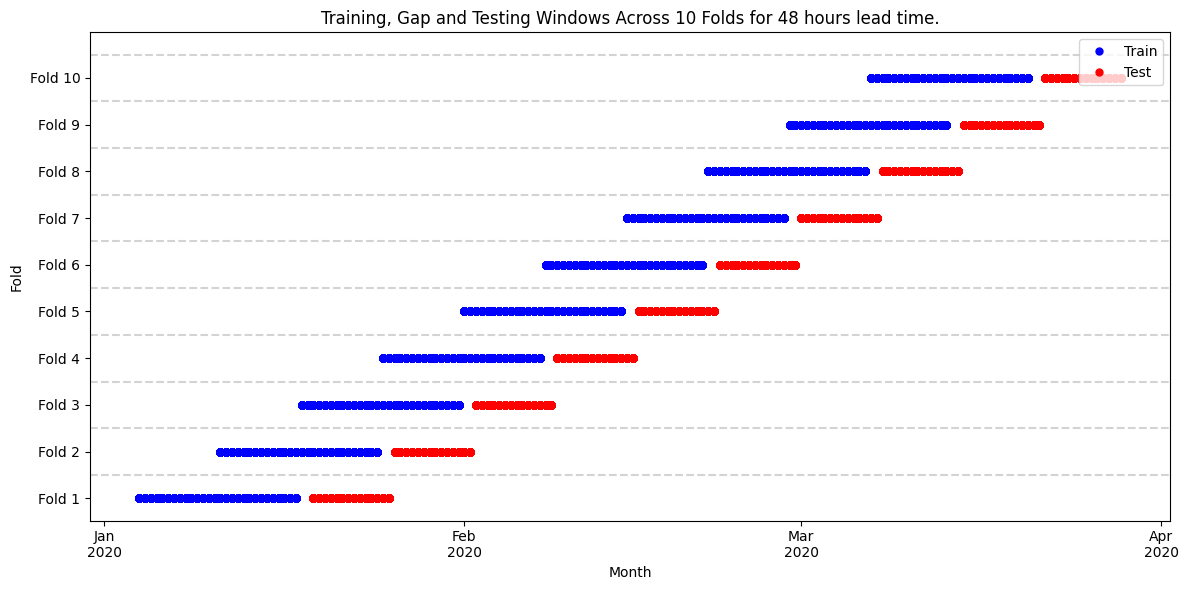

Fold 1:
  mse: 5451.60546875
  PiggyCast: area weighted rmse: 60.38548613455776
  graphcast: area weighted rmse: 66.20678638148297
  pangu: area weighted rmse: 73.25187701683323
  neuralgcm: area weighted rmse: 57.064416422694435
  ifshres: area weighted rmse: 73.25612433115195
Fold 2:
  mse: 8756.2548828125
  PiggyCast: area weighted rmse: 59.10154369781358
  graphcast: area weighted rmse: 67.18696932095679
  pangu: area weighted rmse: 75.6866919914812
  neuralgcm: area weighted rmse: 56.083009122549115
  ifshres: area weighted rmse: 76.64914821516122
Fold 3:
  mse: 8581.4501953125
  PiggyCast: area weighted rmse: 64.29598027667701
  graphcast: area weighted rmse: 72.90208568609224
  pangu: area weighted rmse: 78.45860350690234
  neuralgcm: area weighted rmse: 60.02047684968904
  ifshres: area weighted rmse: 77.68003396303061
Fold 4:
  mse: 7139.53466796875
  PiggyCast: area weighted rmse: 69.21239506587395
  graphcast: area weighted rmse: 74.00325104166043
  pangu: area weighted rmse

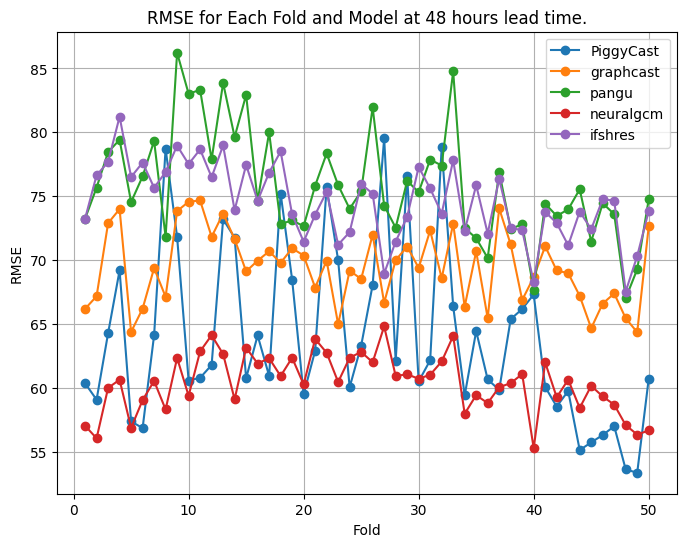

In [21]:
# @title Training and Evaluation Loop- Shorter Time series split

# Initialize xgb regressor
xgb = xgboost.XGBRegressor(random_state=42, device="cuda")

# Calculate Cross-Validation using 10 folds
cv_timeseries = TimeSeriesSplit(n_splits=50, max_train_size=32 * 64 * 2 * 14,
                                test_size= 32 * 64 * 2 * 7, gap=32 * 64 * 2 * 1)

# Lead Times
lead_times=[48]

nested_scores = {} # Nested scores for each lead time
rmse_results = {} # rmse results for each lead time, models

for lead_time in lead_times:
  print(f"======Lead time: {lead_time}========")

  df_filtered = data_per_lead_time(full_df,lead_time)

  X = df_filtered[[f"graphcast_lt{lead_time}", f"pangu_lt{lead_time}",
                   f"neuralgcm_lt{lead_time}",
                  #  f"keisler_lt{lead_time}",
                   f"ifshres_lt{lead_time}", "longitude", "latitude"]]
  y = df_filtered["era5"]
  area_weight = df_filtered["area_weight"]

  print(f"Shape of x :{X.shape}")
  print(f"Shape of y : {y.shape}")

  # Nested Scores
  nested_score = cross_validate(xgb, X=X, y=y, cv=cv_timeseries,
                              scoring=('neg_mean_squared_error', 'r2'),
                              params={'sample_weight': area_weight}
                              )
  nested_scores[lead_time] = nested_score

  # Cross validation plot
  cross_validation_plot(df_filtered, cv_timeseries, lead_time)

  # RMSE
  rmse_result = train_and_evaluate(xgb, cv_timeseries,X,y, area_weight, lead_time)
  rmse_results[lead_time] = rmse_result

  # RMSE plots per model
  rmse_per_fold_plot(rmse_result, lead_time)



Train times Min Date: 2020-01-03 12:00:00 Train times Max Date:2020-01-10 12:00:00
Test times Min Date: 2020-01-12 00:00:00 Test times Max Date:2020-01-18 12:00:00
Train times Min Date: 2020-01-04 00:00:00 Train times Max Date:2020-01-17 12:00:00
Test times Min Date: 2020-01-19 00:00:00 Test times Max Date:2020-01-25 12:00:00
Train times Min Date: 2020-01-11 00:00:00 Train times Max Date:2020-01-24 12:00:00
Test times Min Date: 2020-01-26 00:00:00 Test times Max Date:2020-02-01 12:00:00
Train times Min Date: 2020-01-18 00:00:00 Train times Max Date:2020-01-31 12:00:00
Test times Min Date: 2020-02-02 00:00:00 Test times Max Date:2020-02-08 12:00:00
Train times Min Date: 2020-01-25 00:00:00 Train times Max Date:2020-02-07 12:00:00
Test times Min Date: 2020-02-09 00:00:00 Test times Max Date:2020-02-15 12:00:00
Train times Min Date: 2020-02-01 00:00:00 Train times Max Date:2020-02-14 12:00:00
Test times Min Date: 2020-02-16 00:00:00 Test times Max Date:2020-02-22 12:00:00
Train times Min 

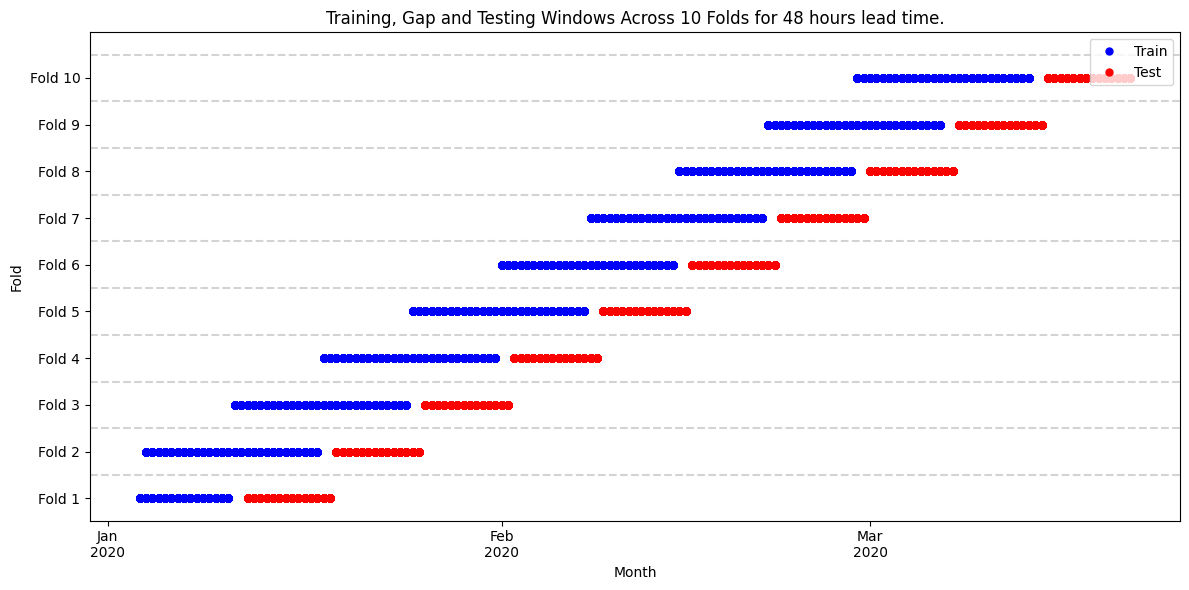

In [27]:
cv_timeseries = TimeSeriesSplit(n_splits=51, max_train_size=32 * 64 * 2 * 14,
                                test_size= 32 * 64 * 2 * 7, gap=32 * 64 * 2 * 1)
cross_validation_plot(df_filtered, cv_timeseries, lead_time)

In [67]:
import pandas as pd

# Parameters
n_samples = 1_497_088
n_splits = 10
max_train_size = 32 * 64 * 2 * 14  # 57344
test_size = 32 * 64 * 2 * 7        # 28672
gap = 32 * 64 * 2 * 1              # 4096

# Calculate fold boundaries
folds = []
for i in range(n_splits):
    test_end = n_samples - (n_splits - 1 - i) * test_size
    test_start = test_end - test_size
    train_end = test_start - gap
    train_start = max(0, train_end - max_train_size)

    folds.append({
        "Fold": i + 1,
        "Train Start": train_start,
        "Train End": train_end - 1,
        "Gap Start": train_end,
        "Gap End": test_start - 1,
        "Test Start": test_start,
        "Test End": test_end - 1,
        "Train Size": train_end - train_start,
        "Test Size": test_size,
    })

# Convert to DataFrame
folds_df = pd.DataFrame(folds)
folds_df


,Fold,Train Start,Train End,Gap Start,Gap End,Test Start,Test End,Train Size,Test Size
0,1,1148928,1206271,1206272,1210367,1210368,1239039,57344,28672
1,2,1177600,1234943,1234944,1239039,1239040,1267711,57344,28672
2,3,1206272,1263615,1263616,1267711,1267712,1296383,57344,28672
3,4,1234944,1292287,1292288,1296383,1296384,1325055,57344,28672
4,5,1263616,1320959,1320960,1325055,1325056,1353727,57344,28672
5,6,1292288,1349631,1349632,1353727,1353728,1382399,57344,28672
6,7,1320960,1378303,1378304,1382399,1382400,1411071,57344,28672
7,8,1349632,1406975,1406976,1411071,1411072,1439743,57344,28672
8,9,1378304,1435647,1435648,1439743,1439744,1468415,57344,28672
9,10,1406976,1464319,1464320,1468415,1468416,1497087,57344,28672


In [58]:
import sklearn
sklearn.__version__

'1.6.1'

In [53]:
print(f"start date: {df_filtered['time'].min()} end date:{df_filtered['time'].max()}")
(df_filtered['time'].max() - df_filtered['time'].min()).days +1

start date: 2020-01-03 12:00:00 end date:2021-01-02 12:00:00


366

In [54]:
df_filtered['time'].unique()

<DatetimeArray>
['2020-01-03 12:00:00', '2020-01-04 00:00:00', '2020-01-04 12:00:00',
 '2020-01-05 00:00:00', '2020-01-05 12:00:00', '2020-01-06 00:00:00',
 '2020-01-06 12:00:00', '2020-01-07 00:00:00', '2020-01-07 12:00:00',
 '2020-01-08 00:00:00',
 ...
 '2020-12-29 00:00:00', '2020-12-29 12:00:00', '2020-12-30 00:00:00',
 '2020-12-30 12:00:00', '2020-12-31 00:00:00', '2020-12-31 12:00:00',
 '2021-01-01 00:00:00', '2021-01-01 12:00:00', '2021-01-02 00:00:00',
 '2021-01-02 12:00:00']
Length: 731, dtype: datetime64[ns]

In [71]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4, 5, 6])
tscv = TimeSeriesSplit()
print(tscv)
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

print("\n================\n")
# Fix test_size to 2 with 120 samples
X = np.random.randn(120, 2)
y = np.random.randint(0, 2, 12)
tscv = TimeSeriesSplit(n_splits=3, test_size=2)
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

print("\n================\n")

# Add in a 2 period gap
tscv = TimeSeriesSplit(n_splits=3, test_size=2, gap=3)
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

print("\n================\n")

# Add in a max train size
tscv = TimeSeriesSplit(n_splits=3, max_train_size=4 ,test_size=2, gap=2)
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)
Fold 0:
  Train: index=[0]
  Test:  index=[1]
Fold 1:
  Train: index=[0 1]
  Test:  index=[2]
Fold 2:
  Train: index=[0 1 2]
  Test:  index=[3]
Fold 3:
  Train: index=[0 1 2 3]
  Test:  index=[4]
Fold 4:
  Train: index=[0 1 2 3 4]
  Test:  index=[5]


Fold 0:
  Train: index=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113]
  Test:  index=[114 115]
Fold 1:
  Train: index=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34

In [ ]:
# @title Calculate RMSE Mean of Model per Lead time

def rmse_mean_per_lead_time_and_model(rmse_results):
  # average scores per lead time and model
  average_scores = {}

  for lead_time, folds in rmse_results.items():
      model_scores = defaultdict(list)

      # collect values per model
      for fold_scores in folds.values():
          for model, value in fold_scores.items():
              model_scores[model].append(value)

      # average for each model
      average_scores[lead_time] = {model: float(np.mean(scores)) for model, scores in model_scores.items()}
  return average_scores



In [ ]:
# print nicely
from pprint import pprint
average_scores = rmse_mean_per_lead_time_and_model(rmse_results)
pprint(average_scores)

{}
